# Automated CAPTCHA Solving With Deep Learning

This notebook demonstrates the use of convolutional neural networks and supervised training to automate CAPTCHA-solving. 

Original Author: Jackon Yang (2017)

Further Modified By: Turhan Kimbrough (2021)

---

In [1]:
# functions from other notebook file
from ipynb.fs.full.shared_functions import *

import tensorflow
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as pyplot
import os

In [2]:
data_directory = os.path.join(os.getcwd() + '/datasets/captcha_img')
image_height = 100
image_width = 100
image_channels = 3
categories = 10 # represents digits 0-9
dimensions = 4  # 4-digit CAPTCHA images

---
## Prepare the Dataset



Store each CAPTCHA-image file path with its respective label
into a pandas DataFrame.

In [3]:
data_frame = create_captcha_dataframe(data_directory)
data_frame.head()

,label,file
0,4773,/home/t-visor/repositories/captcha-tensorflow/...
1,1562,/home/t-visor/repositories/captcha-tensorflow/...
2,8946,/home/t-visor/repositories/captcha-tensorflow/...
3,4378,/home/t-visor/repositories/captcha-tensorflow/...
4,8860,/home/t-visor/repositories/captcha-tensorflow/...


---
Shuffle the data and create a training set, validation set, and testing set.

In [4]:
train_indices, validation_indices, test_indices = shuffle_and_split_data(data_frame)

print('train count: %s, validation count: %s, test count: %s' % (
    len(train_indices), len(validation_indices), len(test_indices)))

train count: 3080, validation count: 1321, test count: 1887


---
## Neural Network Structure

**'relu'** stands for **'Rectified Linear Unit'**, the most commonly used activation function for convolutional neural networks.

**'softmax'** is another activation function used for classifying data.

Activation functions are analagous to the 'firing' of neurons in biological neural networks.

**Layers**:
- Convolutional layer: applies a filter to the CAPTCHA image to extract features (characters and/or digits) from the image
- Pooling layer: immediately follows a convolutional layer and used to downscale the image after each filter is applied
- Flattening layer: converts the CAPTCHA image represented as a 3D tensor (array) to a 1D tensor
- Dense layer: used to assist with operations on an n-dimensional tensor such as rotation, scaling, etc
- Reshape layer: used to restructure the output of the neural network

In [5]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tensorflow.keras.Input(shape=(image_height, image_width, image_channels))

hidden_layers = layers.Conv2D(32, 3, activation='relu')(input_layer)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)
hidden_layers = layers.Conv2D(64, 3, activation='relu')(hidden_layers)
hidden_layers = layers.MaxPooling2D((2, 2))(hidden_layers)

hidden_layers = layers.Flatten()(hidden_layers)

hidden_layers = layers.Dense(1024, activation='relu')(hidden_layers)
hidden_layers = layers.Dense(dimensions * categories, activation='softmax')(hidden_layers)
hidden_layers = layers.Reshape((dimensions, categories))(hidden_layers)

model = models.Model(inputs=input_layer, outputs=hidden_layers)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0     

2021-08-28 13:16:16.552469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-28 13:16:16.553212: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


---
## Train the Model

In [6]:
# get_captcha_generator() was here

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
validation_batch_size = 64
training_set_generator = get_captcha_generator(data_frame, train_indices, \
                                               for_training=True, batch_size=batch_size)
validation_set_generator = get_captcha_generator(data_frame, validation_indices, \
                                                 for_training=True, batch_size=validation_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(training_set_generator,
                    steps_per_epoch=len(train_indices)//batch_size,
                    epochs=10,
                    validation_data=validation_set_generator,
                    validation_steps=len(validation_indices)//validation_batch_size)

Epoch 1/10


2021-08-28 13:16:16.698918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


48/48 [==============================] - 20s 409ms/step - loss: 2.1945 - accuracy: 0.2222 - val_loss: 1.4893 - val_accuracy: 0.5107
Epoch 2/10
48/48 [==============================] - 19s 395ms/step - loss: 0.5330 - accuracy: 0.8408 - val_loss: 0.1034 - val_accuracy: 0.9725
Epoch 3/10
48/48 [==============================] - 20s 417ms/step - loss: 0.0504 - accuracy: 0.9860 - val_loss: 0.0506 - val_accuracy: 0.9846
Epoch 4/10
48/48 [==============================] - 20s 420ms/step - loss: 0.0138 - accuracy: 0.9970 - val_loss: 0.0393 - val_accuracy: 0.9869
Epoch 5/10
48/48 [==============================] - 19s 406ms/step - loss: 0.0049 - accuracy: 0.9994 - val_loss: 0.0335 - val_accuracy: 0.9891
Epoch 6/10
48/48 [==============================] - 19s 398ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.0304 - val_accuracy: 0.9900
Epoch 7/10
48/48 [==============================] - 20s 407ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0302 - val_accuracy: 0.9900
Epoch 8/10

---
## Analyze Model Performance

Plot the accuracy and loss metrics

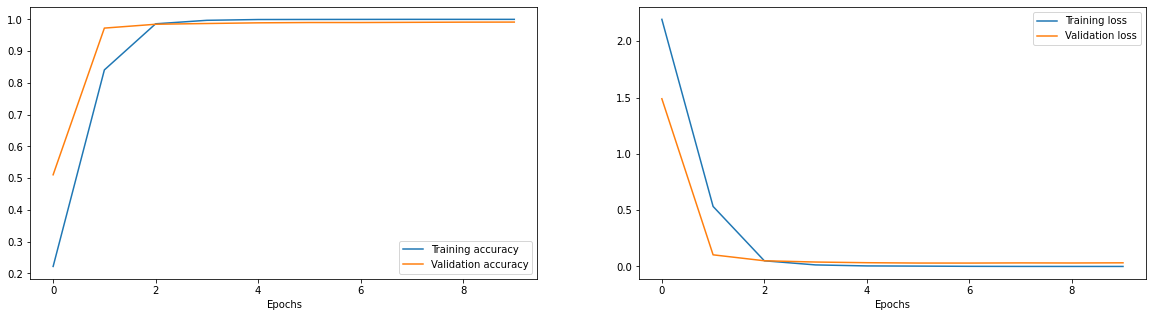

In [8]:
figure, axes = pyplot.subplots(1, 2, figsize=(20, 5))

axes[0].plot(history.history['accuracy'], label='Training accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend() 

axes[1].plot(history.history['loss'], label='Training loss')
axes[1].plot(history.history['val_loss'], label='Validation loss')
axes[1].set_xlabel('Epochs')
axes[1].legend()

Use some 'unseen' test samples

In [9]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(testing_set_generator, steps=len(test_indices)//128)))

14/14 [==============================] - 3s 194ms/step - loss: 0.0363 - accuracy: 0.9891


{'loss': 0.03626207634806633, 'accuracy': 0.9891182780265808}

---
## Visualize Model Performance

In [10]:
testing_set_generator = get_captcha_generator(data_frame, test_indices, for_training=False, batch_size=128)
captcha_images, captcha_text = next(testing_set_generator)

predictions = model.predict_on_batch(captcha_images)

true_values = tensorflow.math.argmax(captcha_text, axis=-1)
predictions = tensorflow.math.argmax(predictions, axis=-1)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


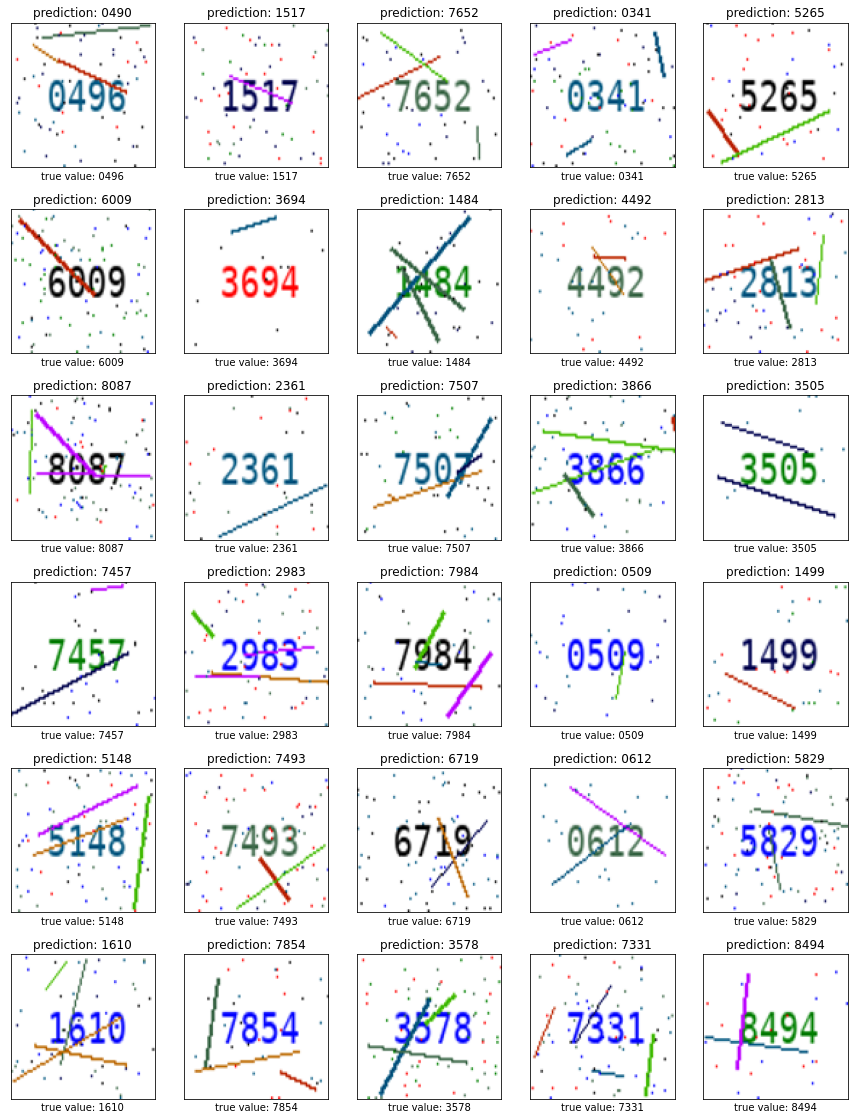

In [11]:
display_predictions_from_model(captcha_images, predictions, true_values)

## Save the Model

In [12]:
#model.save('my_model')